### Группа: ББМО-02-23
### Студент: Васильев Григорий Максимович
### Практика 5: Атака с ограниченной памятью (PGD - Projected Gradient Descent)

**Цель задания:**
Изучить одну из наиболее мощных атак на модели ИИ — атаку Projected Gradient Descent (PGD). Научиться использовать PGD для создания противоречивых примеров и оценить её влияние на обученные модели.

**Задачи:**
* Загрузить ранее обученную модель на датасете MNIST.
* Изучить теоретические основы атаки PGD.
* Реализовать атаку PGD с помощью фреймворка Foolbox.
* Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

Обученную модель 'mnist_model.h5' для загрузки в код можно найти в репозитории перейдя по ссылке: https://github.com/Archangel15520/AZSII-REPO/blob/main/README.md

**Теория атаки Projected Gradient Descent (PGD):**
Атака Projected Gradient Descent (PGD) — это расширение FGSM (Fast Gradient Sign Method), где атака выполняется итеративно. На каждой итерации добавляются небольшие изменения к входным данным в направлении увеличения ошибки модели.

После каждой итерации результат "проецируется" на допустимое пространство для ограничивания размера изменений, что позволяет сохранять противоречивый пример в пределах определенной нормы (например, L∞).

**Установка необходимой библиотеки:**

In [8]:
!pip install foolbox

**Загрузка обученной модели и данных MNIST**

In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 0.0813
Test accuracy on clean images: 0.9786999821662903


**Реализация атаки PGD с использованием Foolbox**


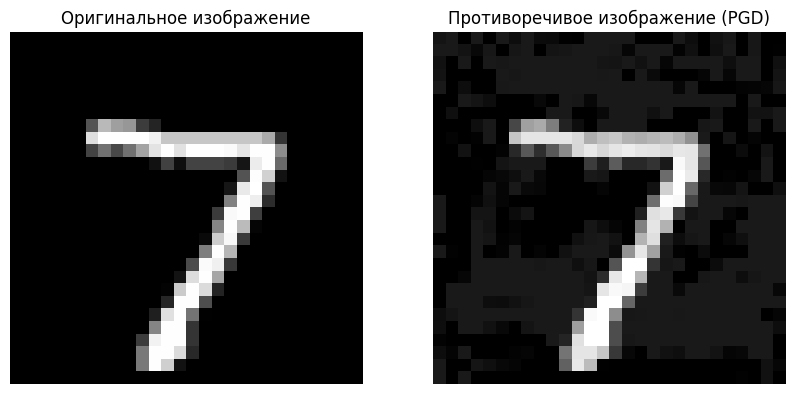

In [12]:
import torch
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.LinfPGD()
advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()


**Оценка модели на противоречивых примерах**

In [13]:
adversarial_images = []

# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0381 - loss: 7.8791
Accuracy on adversarial examples (PGD): 0.051500000059604645


**Вывод:**

Точность модели снизилась с 97.8% на чистых тестовых изображениях до 5.1% на атакованных примерах, что демонстрирует её уязвимость перед атакой PGD. Эта атака, минимально изменяя входные данные, существенно снижает производительность модели, подчёркивая необходимость разработки устойчивых методов машинного обучения.

Для повышения устойчивости модели можно использовать стратегии, такие как аугментация данных с противоречивыми примерами, регуляризация или adversarial training. Также важным шагом является внедрение устойчивых архитектур, способных ограничивать влияние атак, и систематическое тестирование модели на различные виды атак для повышения её надёжности, особенно в критически важных приложениях, где ошибки недопустимы.